In [30]:
import jax.numpy as jnp
import numpy as np

import jax

from jax import grad, jit, vmap, pmap

from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


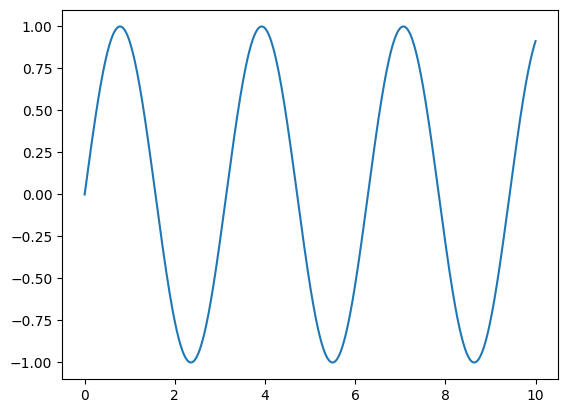

In [ ]:
# Fact 1: JAX's syntax is remarkably similar to NumPy's
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_jnp) * jnp.cos(x_jnp)
plt.plot(x_jnp, y_jnp)

In [ ]:
# Fact 2: JAX arrays are immutable! (embrace the functional programming paradigm)

size = 10
index = 0
value = 23

# NumPy mutable arrays
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [ ]:
y = x.at[index].set(value)
print(x)
print(y)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [ ]:
# Fact 3: JAX handles random numbers differently
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10, ))
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]


In [ ]:
# Fact 4: JAX is AI accelerator agnostic. Some code runs everywhere!

size = 3000

x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit np.dot(x_np, x_np.T)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()

x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()

13.4 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
320 ms ± 95.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
61.9 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.6 ms ± 112 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## JAX transform functions

### `jit()` 101

In [ ]:
def visualize_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, n)
    y = fn(x)
    plt.plot(x, y); plt.show()

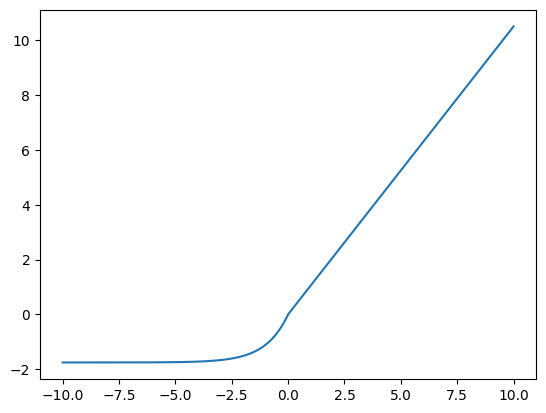

non-jit version:
1.17 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
jit version:
153 µs ± 39.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)

visualize_fn(selu)

data = random.normal(key, (1000000, ))

print('non-jit version:')
%timeit selu(data).block_until_ready()

print('jit version:')
%timeit selu_jit(data).block_until_ready()

### `grad()` 101
Differentiation can be:

- manual
- symbolic
- numeric
- automatic!

In [ ]:
def sum_logistic(x):
    return jnp.sum(x**2)

x = jnp.arange(3.)
loss = sum_logistic

grad_loss = grad(loss)

print(grad_loss(x))

[0. 2. 4.]


In [ ]:
jnp.eye(len(x))

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
def finite_differences(f, x):
    eps = 1e-3
    return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps) for v in jnp.eye(len(x))])

finite_differences(sum_logistic, x)

Array([0.       , 1.9998549, 3.9999483], dtype=float32)

In [ ]:
x = 1.
y = 1.

f = lambda x, y: x**2 + x + 4 + y**2
# visualize_fn(f, l=-1, r=2, n=100)
# 2y
# 2x + 1
dfdx = grad(f)
dfdy = grad(f, argnums=1)  # 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx) # 0

print(f(x, y))
print(dfdx(x, y))
print(dfdy(x, y))   # 2y
print(d2fdx(x, y))
print(d3fdx(x, y))

7.0
3.0
2.0
2.0
0.0


In [ ]:
from jax import jacfwd, jacrev


f = lambda x, y: x**2 + y**2

def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

print(jacrev(f, argnums=(0, 1))(2., 2.))
print(hessian(f)(1., 1.))

(Array(4., dtype=float32, weak_type=True), Array(4., dtype=float32, weak_type=True))
((Array(2., dtype=float32, weak_type=True), Array(0., dtype=float32, weak_type=True)), (Array(0., dtype=float32, weak_type=True), Array(2., dtype=float32, weak_type=True)))


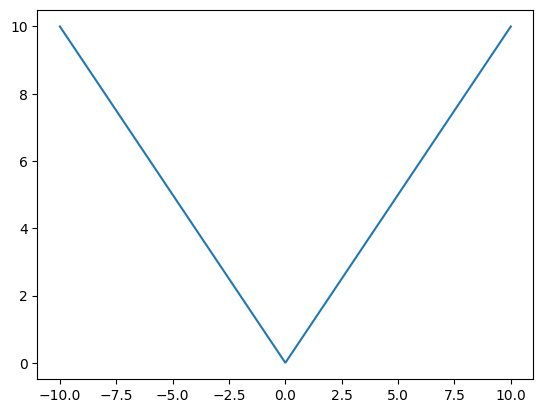

1 1
-1.0 1.0


In [ ]:
f = lambda x: abs(x)
visualize_fn(f)

print(f(-1), f(1))
dfdx = grad(f)
print(dfdx(-1.), dfdx(0.))  # derivative at 0 is 1.

### `vmap()` 101

- Write your functions as if you were dealing with a single datapoint

In [ ]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

def apply_matrix(W, x):
    return jnp.dot(W, x)

In [ ]:
def naively_batched_apply_matrix(batched_x):
    return jnp.stack([apply_matrix(x) for x in batched_x])

print("Naive:")
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naive:


TypeError: apply_matrix() missing 1 required positional argument: 'x'

In [ ]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)

print("Manually batched")
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
114 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
@jit
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)

print("vmap")
%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

vmap
198 µs ± 87.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### How does JIT actually work?

In [ ]:
def norm(X):
    X = X - X.mean(0)
    return X / X.std(0)

norm_compiled = jit(norm)

X = random.normal(key, (10000, 100), dtype=jnp.float32)

%timeit norm(X).block_until_ready()
%timeit norm_compiled(X).block_until_ready()

545 µs ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
220 µs ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10, ), dtype=jnp.float32)
print(x)
print(get_negatives(x))

[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377 -0.1521442
 -0.67135346 -0.5908641   0.73168886  0.5673026 ]
[-0.3721109  -0.18252768 -0.7368197  -0.44030377 -0.1521442  -0.67135346
 -0.5908641 ]


In [ ]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [ ]:
@jit
def f(x, y):
    print(x, y)
    result = jnp.dot(x + 1, y + 1)
    print(result)
    return result

x = np.random.randn(3, 4)
y = np.random.randn(4)
print("First call:")
print(f(x, y))

# not compile again
x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second call:")
print(f(x2, y2))

# compile again
x3 = np.random.randn(3, 5)
y3 = np.random.randn(5)
print("Third call:")
print(f(x3, y3))

First call:
Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[0.2855511 6.634348  6.1266394]
Second call:
[1.0635954 2.8393788 1.5804176]
Third call:
Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[ 3.8150587 10.739914   9.554417 ]


In [ ]:
def f(x, y):
    return jnp.dot(x + 1, y + 1)

print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [ ]:
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at <ipython-input-33-708cfe44bcda>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [ ]:
@jit
def f(x, neg):
    return jnp.where(neg, -x, x)  # Use jnp.where for conditional operations within jit

f(1, True)

Array(-1, dtype=int32, weak_type=True)

In [ ]:
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


In [ ]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod)
    return x.reshape(jnp.array(x.shape).prod())

x = jnp.ones((2, 3))
f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
<bound method _forward_method_to_aval.<locals>.meth of Traced<ShapedArray(int32[2])>with<DynamicJaxprTrace(level=1/0)>>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at <ipython-input-43-21aabbf2fb1b>:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a:i32[2] = convert_element_type[new_dtype=int32 weak_type=False] b
    from line <ipython-input-43-21aabbf2fb1b>:6 (f)

In [ ]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(np.prod(x.shape))
    return x.reshape(np.prod(x.shape))

f(x)

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
6


Array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [ ]:
x = x + 1
f(x)

Array([4., 4., 4., 4., 4., 4.], dtype=float32)

# Gotcha #1: Pure functions

- JAX is designed to work only on pure functions!

Pure function:
1. All the input data is passed through the function parameters, all the results are output through the function results.
2. A pure function will always return the same result if invoked with the same inputs.

In [ ]:
def impure_print_side_effect(x):
    print("Executing function") # Violating #1
    return x

# The side-effects appear during the first run
print("First call: ", jit(impure_print_side_effect)(4.))

# Subsequent runs with parameters of same type and shape may not show the side-effect
# This is because JAX now invokes a cached compiled version of the function
print("Second call: ", jit(impure_print_side_effect)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_print_side_effect)(jnp.ones((2, 3))))

Executing function
First call:  4.0
Second call:  5.0
Executing function
Third call, different type:  [[1. 1. 1.]
 [1. 1. 1.]]


In [ ]:
g = 0.

def impure_uses_globals(x):
    return x + g    # violating both #1 and #2

# JAX captures the value of the global during the first run
print("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global
g = 10.

# Subsequent runs may silently use the cached value of the globals
print("Second call: ", jit(impure_uses_globals)(5.))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_uses_globals)(jnp.ones((2, 3))))

First call:  4.0
Second call:  5.0
Third call, different type:  [[11. 11. 11.]
 [11. 11. 11.]]


In [ ]:
@jit
def pure_uses_internal_state(x):

    state = dict(even=0, odd=0)
    for i in range(10):
        state['even' if i % 2 == 0 else 'odd'] += x

    return state['even'] + state['odd']

print(jit(pure_uses_internal_state)(4.))

40.0


In [ ]:
# lax.fori_loop; similarly for lax.scan, lax.cond, etc.
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i, x: x + array[i], 0))   # expected result 45

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i, x: x + next(iterator), 0))

45
0


# Gotcha #2: In-Place Updates

In [ ]:
jax_array = jnp.zeros((3, 3), dtype=jnp.float32)
updated_array = jax_array.at[1, :].set(1.0)

print("original array")
print(jax_array)

print("updated array")
print(updated_array)

original array
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
updated array
[[0. 0. 0.]
 [1. 1. 1.]
 [0. 0. 0.]]


In [ ]:
print("original array")
jax_array = jnp.ones((5, 6))
print(jax_array)

print("new array post-addition")
new_jax_array = jax_array.at[::2, 3:].add(7.)
print(new_jax_array)

original array
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
new array post-addition
[[1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 8. 8. 8.]]


# Gotcha #3: Out-of-Bounds Indexing

Due to JAX's accelerator agnostic approach, it had to make a non-error behaviour for out of bound indexing (similarly to how invalid fp arithmetic results in NaNs and not an exception).


In [ ]:
# Numpy behaviour

try:
    np.arange(10)[11]
except IndexError as e:
    print(e)

index 11 is out of bounds for axis 0 with size 10


In [ ]:
# JAX behaviour
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(10).at[11].add(23))    # example of 1)
print(jnp.arange(10)[11])                # example of 2)

[0 1 2 3 4 5 6 7 8 9]
9


# Gotcha #4: Non-array Inputs
- This is added by design (performance reasons)

In [ ]:
# Numpy

print(np.sum([1, 2, 3]))

6


In [ ]:
# JAX

try:
    jnp.sum([1, 2, 3])
except TypeError as e:
    print(e)

sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [ ]:
# Why? jaxpr to the rescue!

def permissive_sum(x):
    return jnp.sum(jnp.array(x))

x = list(range(10))
print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

In [ ]:
x = np.arange(10)
print(make_jaxpr(permissive_sum)(x))

{ lambda ; a:i32[10]. let
    b:i32[10] = copy a
    c:i32[] = reduce_sum[axes=(0,)] b
  in (c,) }


just remember to input nd_array or jax array!

# Gotcha #5: random numbers

In [ ]:
# NumPy - PRNG is stateful!

# Let's sample calling the same function twice
print(np.random.random())
print(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
print(rng_state[2:])

# Mersenne Twister PRNG is known to have a number of problems (Numpy's imp of PRNG)

0.24899891768433358
0.5554186616881994
(624, 0, 0.0)
(2, 0, 0.0)
(4, 0, 0.0)


In [ ]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))   # same results?
print(key)

[0 0]
[-0.20584226]
[0 0]
[-0.20584226]
[0 0]


In [ ]:
# Solution? -> Split every time we need a pseudorandom number

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("new key", key)
print("new subkey", subkey)
print(normal_pseudorandom)

# Note1: we can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

old key [3382499631 3878610767]
new key [1226047270 2014510724]
new subkey [1194623263 2038155241]
[0.21714099]


In [ ]:
# Why this design?
# 1) reproducible?
# 2) parallelizable?
# 3) vectorizable?

np.random.seed(seed)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

def foo():
    return bar() + 2 * baz()    # 1st 0.3 2nd 0.4 [0.3 + 2*0.4] [0.4 + 2*0.3]

print(foo())    # the same result everytime we run this
# What if we want to parallelize this code? NumPy assumes too much. 2) is violated

1.9791922366721637


In [ ]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once:", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)

print("individually:", jnp.stack([random.uniform(subkey) for subkey in subkeys]))

key = random.PRNGKey(seed)
print("all at once:", random.uniform(key, shape=(3,)))

# NumPy violates 3)

individually: [0.5488135  0.71518937 0.60276338]
all at once: [0.5488135  0.71518937 0.60276338]
individually: [0.86839545 0.7184181  0.80332327]
all at once: [0.9653214  0.31468165 0.63302994]


# Gotcha #6: Control Flow

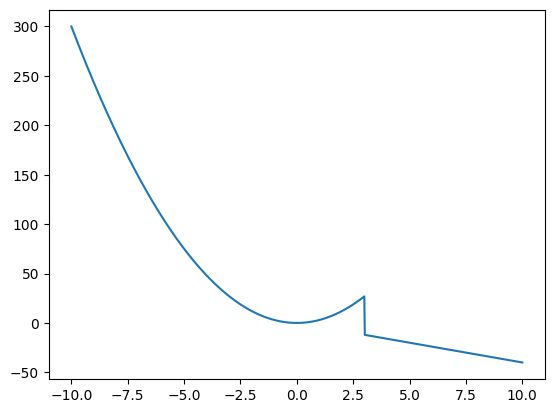

12.0
-4.0
-4.0


In [20]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y); plt.show()

print(grad(f)(2.))
print(grad(f)(3.))
print(grad(f)(4.))

In [21]:
# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations),
# but we require more constraints on the Python code to complete the trace."

# Example 1: conditioning on value (same function as in the above cell)
# Solution (static_argnums)
f_jit = jit(f, static_argnums=(0,))
x = 2.

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

{ lambda ; . let
    a:f32[] = pjit[name=f jaxpr={ lambda ; . let  in (12.0,) }] 
  in (a,) }
12.0


In [23]:
# Example 2: range depends on value again.

def f(x, n):
    y = 0.
    for i in range(n):
        y = y + x[i]
    return y

f_jit = jit(f, static_argnums=(1, ))
x = (jnp.array([2., 3., 4.]), 15)

print(make_jaxpr(f_jit, static_argnums=(1,))(*x))   # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

{ lambda ; a:f32[3]. let
    b:f32[] = pjit[
      name=f
      jaxpr={ lambda ; c:f32[3]. let
          d:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] c
          e:f32[] = squeeze[dimensions=(0,)] d
          f:f32[] = add 0.0 e
          g:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] c
          h:f32[] = squeeze[dimensions=(0,)] g
          i:f32[] = add f h
          j:f32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] c
          k:f32[] = squeeze[dimensions=(0,)] j
          l:f32[] = add i k
          m:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 3
          n:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] c m
          o:f32[] =

In [28]:
# Even "better" (despite less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i, val: val + x[i]
    return lax.fori_loop(0, n, body_fun, 0.)

f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = pjit[
      name=f_fori
      jaxpr={ lambda ; d:f32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:f32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
                n:i32[] = add m 3
                o:i32[] = select_n l h n
                p:f32[1] = dynamic_slice[slice_sizes=(1,)] g o
                q:f32[] = squeeze[dimensions=(0,)] p
                r:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] j
                s:f32[] = add r q
              in (k, i, s) }
            body_nconsts=1
            cond_jaxpr={ lambda ; t:i32[] u:i32[] v:f32[]. let
                w:bool[] = lt t u
              in (w,) }
            cond_nconsts=0
          ] d 0 e 0.0
        in (f,) }
    ] a b
  

In [40]:
# Example 3: this is not problematic (it'll only cache a single branch)

def log2_if_rank_2(x):
    print("Cache function")
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2.0)
        return ln_x / ln_2
    else:
        return x

print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

Cache function
{ lambda ; a:i32[3]. let  in (a,) }


In [41]:
jit_log2_if_rank_2 = jit(log2_if_rank_2)

print(jax.make_jaxpr(jit_log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

Cache function
{ lambda ; a:i32[3]. let
    b:i32[3] = pjit[
      name=log2_if_rank_2
      jaxpr={ lambda ; c:i32[3]. let  in (c,) }
    ] a
  in (b,) }


In [48]:
jit_log2_if_rank_2(jax.numpy.array([9]))

Array([9], dtype=int32)